Notebook to help visualize a wave

In [1]:
import netCDF4 as nc
import numpy as np
from salishsea_tools import viz_tools, tidetools
from nowcast import analyze

import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

In [2]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy = grid.variables['Bathymetry'][:]
X = grid.variables['nav_lon'][:]
Y = grid.variables['nav_lat'][:]

[250, 350, 300, 400]

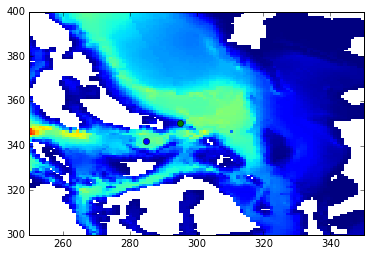

In [3]:
plt.pcolormesh(bathy)
iBP = 285
jBP = 342

iSG = 295
jSG = 350

plt.plot(iBP,jBP,'o')
plt.plot(iSG,jSG,'o')

plt.axis([250,350,300,400])

In [4]:
dmy='17jun15'

path = '/results/SalishSea/nowcast/{}/'.format(dmy)
fT = nc.Dataset(glob.glob(os.path.join(path,'SalishSea_1h_*_grid_T.nc'))[0])
sal = fT.variables['vosaline']
depths = fT.variables['deptht'][:]

fU = nc.Dataset(glob.glob(os.path.join(path,'SalishSea_1h_*_grid_U.nc'))[0])
u = fU.variables['vozocrtx']
u=np.ma.masked_values(u,0)

fV = nc.Dataset(glob.glob(os.path.join(path,'SalishSea_1h_*_grid_V.nc'))[0])
v = fV.variables['vomecrty']
v=np.ma.masked_values(v,0)

#unstagger
u,v = viz_tools.unstagger(u,v)


In [5]:
def salinity_depth(t,ax,lev,ymin=300,ymax=400,zmin=0,zmax=100,i=iSG):
    ax.clear()
    salP=np.ma.masked_values(sal[t,:,:,i],0)
    mesh=ax.contourf(np.arange(898),depths,salP,slevs,vmin=smin, vmax=smax)
    ax.contour(np.arange(898),depths,salP, slevs,colors='k')
    ax.contour(np.arange(898),depths,salP, [lev],colors='b')
    ax.set_xlim([ymin,ymax])
    ax.set_ylim([zmax,zmin])
    ax.set_title(t)
    return mesh

In [6]:
smin, smax, st= 20,30,0.5
slevs = np.arange(smin,smax+st, st)
ts=np.arange(0,24)

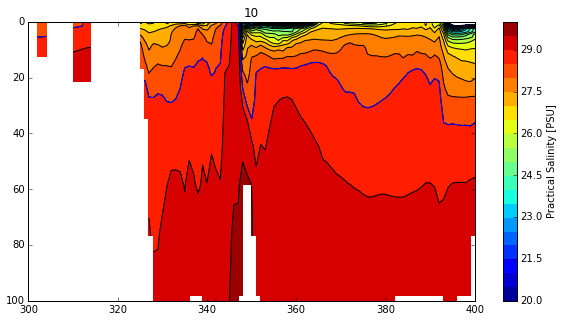

In [7]:
t=10
lev=28.5
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mesh=salinity_depth(t,ax,lev)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity [PSU]')

In [8]:
def quiver_salinity(t,ax,salP):
    ax.clear()
    #mesh
    mesh=ax.contourf(salP,slevs,extend='both')
    #land
    viz_tools.plot_land_mask(ax,grid,color='burlywood')
    viz_tools.plot_coastline(ax,grid)
    #quivers
    xs=np.arange(397); ys=np.arange(897)
    quiver = ax.quiver(xs[::st],ys[::st],u[t,0,::st,::st], v[t,0,::st,::st],
                       pivot='mid', width=0.005,scale=15, color='white',
                       headwidth=2.5,headlength=2)
    ax.quiverkey(quiver,-122.6,48.9, 1, '1 m/s',
                 coordinates='data', color='white', labelcolor='white')
    
    #title
    ax.set_title('t={}'.format(t))
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('y')

    
    return mesh

In [9]:
from mpl_toolkits.mplot3d import Axes3D

In [10]:
def plot_contour_3d(iss, lev,t,ax1,ax2,ymin,ymax,zmin,zmax):
    for i in iss:
        salP=np.ma.masked_values(sal[t,:,:,i],0)
        c = ax1.contour(yy,zz,salP,[lev])
        paths = c.collections[0].get_paths()
        for p in paths:
            y=p.vertices[:,0]
            z=p.vertices[:,1]
            inds=np.where(np.logical_or(y<ymin,y>ymax))
            y[inds] = np.nan
            inds=np.where(np.logical_or(z<zmin,z>zmax))
            z[inds] = np.nan
            if i==iSG:
                ax2.plot3D(i*np.ones(y.shape[0]),y,z, 'b',lw=2)
            else:
                ax2.plot3D(i*np.ones(y.shape[0]),y,z, 'r')
    ax2.set_title('Salinity contour {}'.format(lev))

In [11]:
def visualize_wave_3d(t,st,iss,i,lev,xmin,xmax,ymin,ymax,zmin,zmax):
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    fig = plt.figure(figsize=(15,8))
    ax2 = fig.add_subplot(111, projection='3d')
    fig = plt.figure(figsize=(15,5))
    ax3 = fig.add_subplot(111)

    #3d plot
    plot_contour_3d(iss,lev,t,ax1,ax2,ymin,ymax,zmin,zmax)
    ax2.set_xlim3d([xmin,xmax])
    ax2.set_ylim3d([ymin,ymax])
    ax2.set_zlim3d([zmax,zmin])
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.view_init(elev=60., azim=-20)
    xx,yy=np.meshgrid(np.arange(xmin,xmax),np.arange(ymin,ymax))
    cset = ax2.contour(xx,yy, bathy.data[ymin:ymax,xmin:xmax], [0],
                    zdir='z', offset=zmax, colors='k')
    #Quiver
    ax1.clear()
    salP=np.ma.masked_values(sal[t,0,:,:],0)
    mesh=quiver_salinity(t,ax1,salP)
    cbar = plt.colorbar(mesh, ax=ax1)
    cbar.set_label('Practical Salinity [PSU]')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    #mesh
    mesh=salinity_depth(t,ax3,lev,ymin=ymin,ymax=ymax,zmin=zmin,zmax=zmax,i=i)
    cbar = plt.colorbar(mesh, ax=ax3)
    cbar.set_label('Practical Salinity [PSU]')
    ax1.plot([iSG,iSG],[ymin,ymax],'k--')

## Output time 10

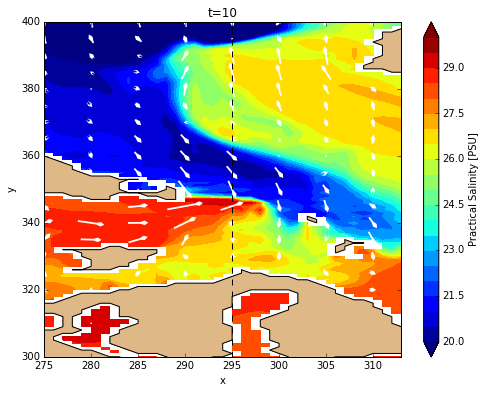

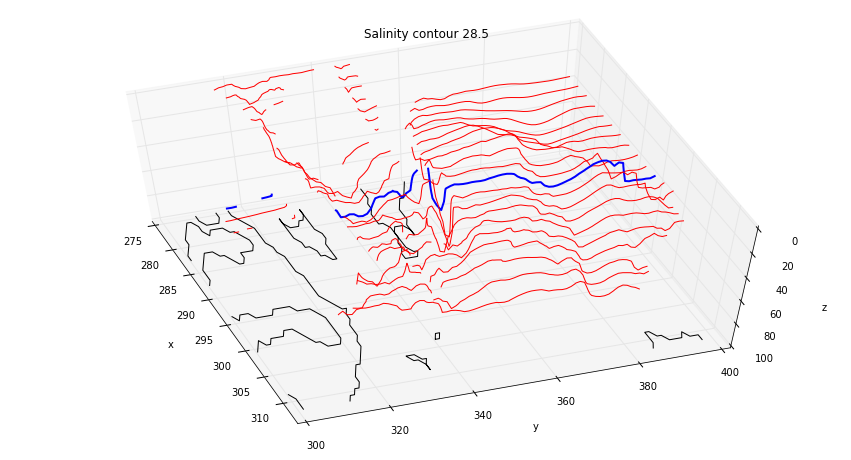

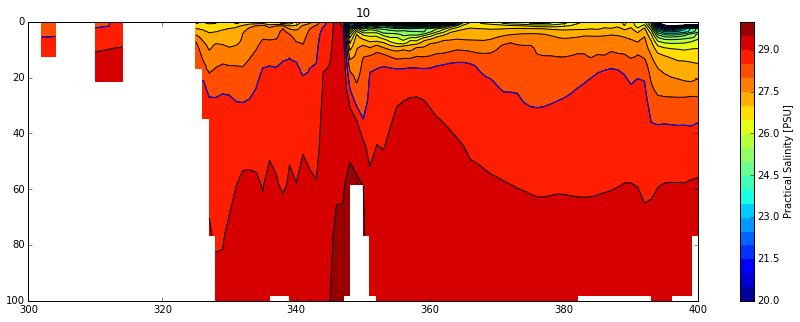

In [12]:
st=5
t=10
iss=np.arange(iSG-20,iSG+20,2)
lev=28.5
xmin, xmax=iss[0],iss[-1]
ymin,ymax=300,400
zmin,zmax=0,100
yy,zz=np.meshgrid(np.arange(898),np.array(depths))

visualize_wave_3d(t,st,iss,iSG,lev,xmin,xmax,ymin,ymax,zmin,zmax)



## Output time 21

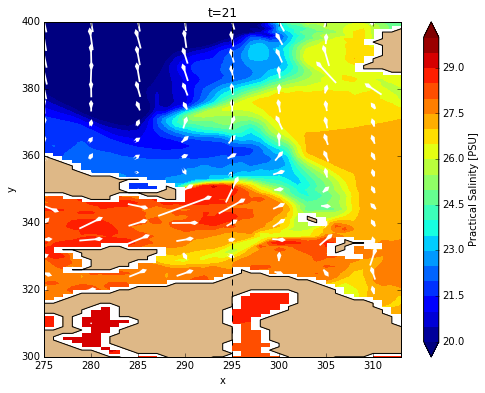

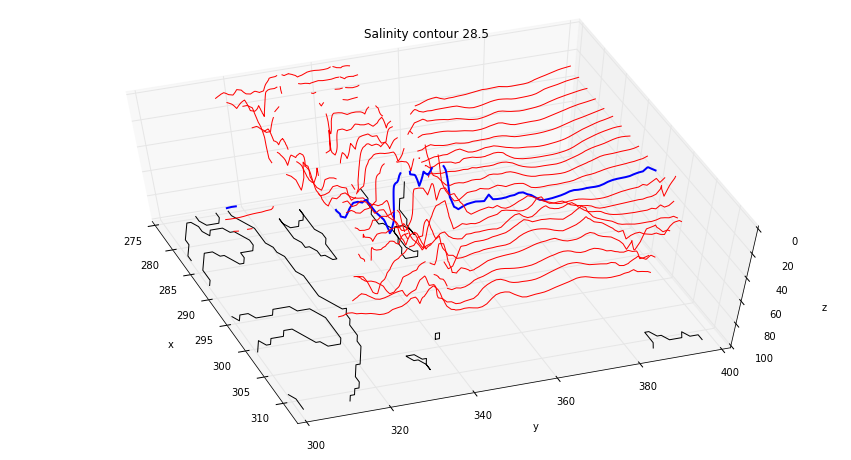

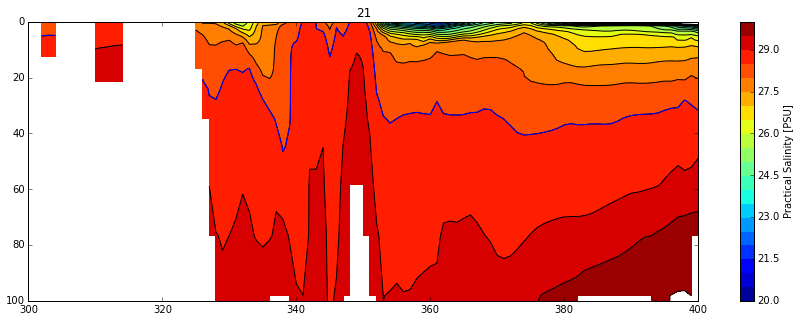

In [13]:
st=5
t=21

visualize_wave_3d(t,st,iss,iSG,lev,xmin,xmax,ymin,ymax,zmin,zmax)